# Исследование продаж видеоигр в интернет-магазине "Стримчик"

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.

**Цель** - выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й.

Данные для исследования:
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


## Изучение данных из файла

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import plotly.io as pio
pio.renderers.default = 'notebook_connected'

from scipy import stats as st
from plotly.subplots import make_subplots

In [2]:
try:
  df = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
except Exception as err:
  print('Ошибка:', err)

In [3]:
display(df.head())
df.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Вывод

1. Есть пропущенные значения
2. Неверные типы данных
3. Столбцы нужны привести к нижнему регистру

Данные прочитаны, приступим к предобработке данных

## Предобработка данных


Для начала приведем названия столбцов к нижнему регистру.

In [4]:
df.columns = df.columns.str.lower()

### Обработка пропусков

Посмотрим, сколько у нас пропусков

In [5]:
pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
name,0.010000
platform,0.000000
year_of_release,1.610000
genre,0.010000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.320000
user_score,40.090000


Видим одинаковое количество пропусков в столбце с именем и жанром игры, посмотрим на строки и выясним, не к одной и той же строке относятся эти пропуски.

In [6]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Да, это одни и те же строки. 2 строки, где пропущены и названия, и жанр. Это всего 0.01% от датафрейма. Эти строки, я считаю, неинформативны для нас, и их можно спокойно удалить.

In [7]:
df.dropna(subset=['name'], inplace=True)

В столбце с годом выпуска игры 1.6% пропусков. Данных для адеватного заполнения у нас нет, поэтому просто заполним маркером -1. Главное - не использовать эти строки в дальнейшем анализе

In [8]:
df['year_of_release'].fillna(-1, inplace=True)

В столбце user_score есть значения tbd, посмотрим на них

In [9]:
df.query('user_score == "tbd"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,-1.0,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001.0,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003.0,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008.0,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008.0,Simulation,0.01,0.00,0.0,0.00,NaN,tbd,E


**Tbd** - to be determined - **будет определено позднее**, то есть у них рейтинг еще не сформировался. Нужно это обработать для приведения к численному типу данных. Заменим tbd на NaN

In [10]:
df['user_score'].replace('tbd', np.NaN, inplace=True)
df['user_score'] = df['user_score'].astype('float')

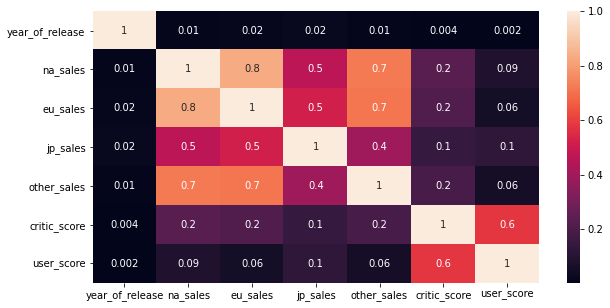

In [11]:
plt.subplots(figsize=(10,5))
sns.heatmap(df.query('user_score == user_score').corr(), annot = True, fmt='.1g')
plt.show()

В critic score и rating пропущено очень много значений. Средним или медианой, я думаю, заполнять нельзя, исказим данные, поэтому оставим пропуски

In [12]:
pd.DataFrame(round((df.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
name,0.000000
platform,0.000000
year_of_release,0.000000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.310000
user_score,54.590000


Готово, перейдем к замене типа данных

### Замена типа данных

In [13]:
df.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
dtype: object

Заменяем:
* year_of_release на **int**, потому что год - целочисленный тип

In [14]:
df['year_of_release'] = df['year_of_release'].astype('int')

### Расчеты

Добавим столбец с суммарными продажами игр

In [15]:
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

In [16]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


### Вывод

* Обработали пропуски. Некоторые пропуски не были заполнены за неимением данных, к примеру, tbd - оценка еще не была сформирована. 
* Заменили тип данных.
* Добавили столбец с суммарными продажами во всех регионах

## Исследовательский анализ данных

### Посмотрим, сколько игр выпускалось в разные годы.

In [17]:
dr = (
    df
        .query('year_of_release != -1')
        .groupby('year_of_release', as_index=False)
        .agg({'name':'count'})
        .rename(columns={'name':'count'})
)

fig = px.bar(dr, x='year_of_release', y='count',
             title='Количество выпущенных игр по годам')
fig.show()

Игры начали выпускать с 1980 года, но на протяжении 10 лет они почти не пользовались спросом. Для нашего исследования лучше взять года, когда видеоигры получили народное признание. Поэтому лучше всего будет взять данные, начиная с 1995 года, когда спрос на видеоигры начал стремительно расти.

### Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы

Найдем топ 10 платформ с наибольшими суммарными продажами

In [18]:
top_platform = (
    df
        .groupby('platform')
        .agg({'total_sales':'sum'})
        .sort_values(by='total_sales', ascending=False)
        .head(10)
)
top_platform

,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12
PS,730.86
GBA,317.85
PS4,314.14
PSP,294.05


In [19]:
top_platform_year = (
    df
        .query('platform in @top_platform.index and year_of_release >= 1995')
        .pivot_table(index='year_of_release',
                     columns='platform',
                     values='total_sales',
                     aggfunc='sum')
        .fillna(0)
)
top_platform_year

platform,DS,GBA,PC,PS,PS2,PS3,PS4,PSP,Wii,X360
year_of_release,,,,,,,,,,
1995,0.00,0.00,4.22,35.96,0.00,0.00,0.00,0.00,0.00,0.00
1996,0.00,0.00,10.58,94.70,0.00,0.00,0.00,0.00,0.00,0.00
1997,0.00,0.00,11.27,136.17,0.00,0.00,0.00,0.00,0.00,0.00
1998,0.00,0.00,3.26,169.49,0.00,0.00,0.00,0.00,0.00,0.00
1999,0.00,0.00,4.74,144.53,0.00,0.00,0.00,0.00,0.00,0.00
2000,0.00,0.07,4.66,96.37,39.17,0.00,0.00,0.00,0.00,0.00
2001,0.00,61.53,5.47,35.59,166.43,0.00,0.00,0.00,0.00,0.00
2002,0.00,74.16,8.57,6.67,205.38,0.00,0.00,0.00,0.00,0.00
2003,0.00,56.67,8.84,2.07,184.31,0.00,0.00,0.00,0.00,0.00


In [20]:
dr = (
    df
        .query('platform in @top_platform.index and year_of_release >= 1995')
        .groupby(['year_of_release', 'platform'], as_index=False)
        .agg({'total_sales':'sum'})
)

fig = px.bar(dr, x='year_of_release', y='total_sales', color='platform',
             title='Продажи на разных платформах по годам, млн. копий')

fig.show()

Прекрасно видно, что в среднем платформа "живет" примерно 8 лет. 

Значит, по сути, для прогноза на 2017 год актуальным будет период с 2009 года. Но, если посмотреть на график, то мы увидим, что данные с 2009 года могут подпортить нам результаты, потому что, к примеру, платформы 'Wii', 'PS3', 'X360' к 2016 году уже "прожили свое", а 'PS4', который сейчас 'на высоте', появился только в 2013 году. Так что, считаю, что будет правильнее считать актуальным период с 2013 года.


### Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

Мы решили, что актуальным для нас будет период с 2013 года

In [21]:
df = df.query('year_of_release >= 2013').reset_index(drop=True)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
4,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62


### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

Посмотрим на продажи по платформам

In [22]:
dr = (
    df
        .groupby('platform', as_index=False)
        .agg({'total_sales':'sum'})
        .sort_values(by='total_sales')
)

fig = px.bar(dr, x='platform', y='total_sales',
             color='total_sales',
             title='Продажи на разных платформах, млн. копий')
fig.show()

Лидирует по продажам у нас 'PS4', 'PS3', 'XOne', '3DS' и 'X360' 

Посмотрим каким платформы растут/падают

In [23]:
dr = (
    df
        .groupby(['year_of_release', 'platform'], as_index=False)
        .agg({'total_sales':'sum'})
)

fig = px.bar(dr, x='year_of_release', y='total_sales', color='platform', barmode='group',
             title='Продажи на разных платформах по годам, млн. копий')

fig.show()

* Видно, что 3DS стремительно теряет популярность, DS уже в гробу
* PC тоже медленно теряет продажи
* PS4 заменяет PS3 и держит высокую планку
* PSP ушел в мир иной, PSV, Wii, WiiU уже встали на его путь
* XOne заменяет X360 и держит топ-2

Потенциально прибыльные платформы - однозначно PS4, XOne, PC и 3DS в Японии

### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

In [24]:
fig = px.box(df, x='total_sales', y='platform', orientation='h')
fig.update_xaxes(range=[0, 5])
fig.show()

Больше всего продали игр для платформ X360, XOne, PS4 и Wii

### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Будем исследовать самую популярную платформу - PS4

In [25]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(
    go.Scatter(x=df.query('platform == "PS4"')['critic_score'],
               y=df.query('platform == "PS4"')['total_sales'],
               name='Оценка критиков', mode='markers'), row=1, col=1)
fig.add_trace(
    go.Scatter(x=df.query('platform == "PS4"')['user_score'],
               y=df.query('platform == "PS4"')['total_sales'],
               name='Оценка пользователей', mode='markers'), row=2, col=1)

fig.update_layout(title='Влияние отзывов критиков и пользователей на продажи')

fig.show()

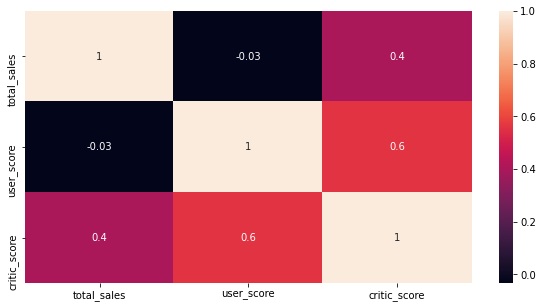

In [26]:
plt.subplots(figsize=(10,5))
sns.heatmap(df.query('platform == "PS4"')[['total_sales', 'user_score', 'critic_score']].corr(), annot = True, fmt='.1g')
plt.show()

Судя по матрице корреляции, оценки пользователей никак не влияют на объем продаж, когда как отзывы критиков хоть и несильно, но могут повлиять на продажи - коэф. корреляции -0.03 и 0.4 соответственно

### Соотнесите выводы с продажами игр на других платформах

Проверим выводу с продажим игр на других популярных и прибыльных платформах. Напомню, это PS4 (уже посмотрели), XOne и PC. И заодно посмотрим еще на PS3 и X360, чтоб наверняка

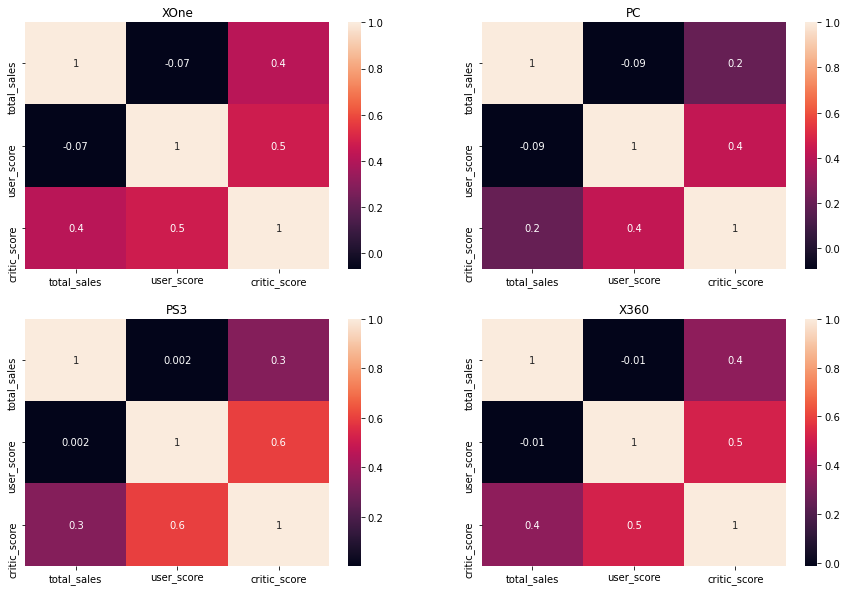

In [27]:
fig, ax = plt.subplots(2,2, figsize=(15, 10))

sns.heatmap(df.query('platform == "XOne"')[['total_sales', 'user_score', 'critic_score']].corr(), annot = True, fmt='.1g', ax=ax[0,0])
ax[0,0].set_title('XOne')

sns.heatmap(df.query('platform == "PC"')[['total_sales', 'user_score', 'critic_score']].corr(), annot = True, fmt='.1g', ax=ax[0,1])
ax[0,1].set_title('PC')

sns.heatmap(df.query('platform == "PS3"')[['total_sales', 'user_score', 'critic_score']].corr(), annot = True, fmt='.1g', ax=ax[1,0])
ax[1,0].set_title('PS3')

sns.heatmap(df.query('platform == "X360"')[['total_sales', 'user_score', 'critic_score']].corr(), annot = True, fmt='.1g', ax=ax[1,1])
ax[1,1].set_title('X360')

plt.show()

Результат практически не отличается и на других платформах.

Значит, можно сделать вывод - на объем продаж влияют только оценки критиков, отзывы пользователей роли не играют.

### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [28]:
dr = (
    df
        .groupby('genre', as_index=False)
        .agg({'total_sales':'sum'})
        .sort_values(by='total_sales')
)

fig = px.bar(dr, x='genre', y='total_sales', color='total_sales',
             title='Продажи игр по жанрам')
fig.show()

Топ-3 по объему продаж - это жанры action, shooter и sports.

А жанры - simulation, puzzle и strategy почти не пользуются спросом среди геймеров

Посмотрим на средние показатели жанров

In [29]:
fig = px.box(df, x='total_sales', y='genre', orientation='h')
fig.update_xaxes(range=[0, 4], row=1, col=1)
fig.show()

Здесь картина чуть другая. Топ-3 по средним показателям - жанры shooter, sports и platform. 

## Портрет пользователя каждого региона (NA, EU и JP)

### Самые популярные платформы.

In [30]:
dr = (
    df
        .groupby('platform', as_index=False)
        .agg({'na_sales':'sum',
              'eu_sales':'sum',
              'jp_sales':'sum',
              'total_sales':'sum'})
        .sort_values(by='na_sales')
)
dr

,platform,na_sales,eu_sales,jp_sales,total_sales
5,PSP,0.00,0.17,3.29,3.50
1,DS,0.57,0.85,0.00,1.54
6,PSV,5.04,6.10,18.59,32.99
7,Wii,6.56,5.93,0.05,13.66
2,PC,11.11,25.36,0.00,39.43
8,WiiU,29.21,19.85,10.88,64.63
0,3DS,38.20,30.96,67.81,143.25
3,PS3,63.50,67.81,23.35,181.43
9,X360,81.66,42.52,0.51,136.80
10,XOne,93.12,51.59,0.34,159.32


In [31]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Bar(x=dr['platform'], y=dr['na_sales'],
           name='Северная Америка'), row=1, col=1)
fig.add_trace(
    go.Bar(x=dr['platform'], y=dr['eu_sales'],
           name='Европа'), row=2, col=1)
fig.add_trace(
    go.Bar(x=dr['platform'], y=dr['jp_sales'],
           name='Япония'), row=3, col=1)

fig.update_layout(title='Суммарные продажи по платформам')

fig.show()

Посмотрим на доли продаж

In [32]:
df_na = (
    df
        .groupby('platform')
        .agg({'na_sales':'sum',
              'total_sales':'sum'})
        .sort_values(by='na_sales', ascending=False)
        .head()
)
df_na['ratio'] = round(df_na['na_sales'] / df_na['total_sales'], 2)
df_na

,na_sales,total_sales,ratio
platform,,,
PS4,108.74,314.14,0.35
XOne,93.12,159.32,0.58
X360,81.66,136.80,0.60
PS3,63.50,181.43,0.35
3DS,38.20,143.25,0.27


In [33]:
df_eu = (
    df
        .groupby('platform')
        .agg({'eu_sales':'sum',
              'total_sales':'sum'})
        .sort_values(by='eu_sales', ascending=False)
        .head()
)
df_eu['ratio'] = round(df_eu['eu_sales'] / df_eu['total_sales'], 2)
df_eu

,eu_sales,total_sales,ratio
platform,,,
PS4,141.09,314.14,0.45
PS3,67.81,181.43,0.37
XOne,51.59,159.32,0.32
X360,42.52,136.80,0.31
3DS,30.96,143.25,0.22


In [34]:
df_jp = (
    df
        .groupby('platform')
        .agg({'jp_sales':'sum',
              'total_sales':'sum'})
        .sort_values(by='jp_sales', ascending=False)
        .head()
)
df_jp['ratio'] = round(df_jp['jp_sales'] / df_jp['total_sales'], 2)
df_jp

,jp_sales,total_sales,ratio
platform,,,
3DS,67.81,143.25,0.47
PS3,23.35,181.43,0.13
PSV,18.59,32.99,0.56
PS4,15.96,314.14,0.05
WiiU,10.88,64.63,0.17


* Почти 50% игр на PS4 продаются в Европе, 80% продаж приходится на Северную Америку и Европу. 

* Игры на X360 и XOne больше всего покупают в Северной Америке - 60% и 58% соответственно от всех продаж.

* На Японию приходится 50% игр на 3DS и столько же на PSV. На PS4 и PS3 приходится всего 18% от мирового оборота. 

### Самые популярные жанры.

In [35]:
dr = df.groupby('genre', as_index=False)['na_sales'].sum().sort_values(by='na_sales').tail()

fig = px.bar(dr, x='genre', y='na_sales',
             title='Топ-5 жанров в Северной Америке')
fig.show()

In [36]:
dr = df.groupby('genre', as_index=False)['eu_sales'].sum().sort_values(by='eu_sales').tail()

fig = px.bar(dr, x='genre', y='eu_sales',
             title='Топ-5 жанров в Европе')
fig.show()

In [37]:
dr = df.groupby('genre', as_index=False)['jp_sales'].sum().sort_values(by='jp_sales').tail()

fig = px.bar(dr, x='genre', y='jp_sales',
             title='Топ-5 жанров в Японии')
fig.show()

В Европе и Северной Америке топ-5 жанров почти полностью совпадают - лидером является жанр Action, отличаются лишь 5 местом - в Европе это Racing, а в Америке - Misc

Япония как всегда выделяется - на первом месте здесь жанр Role-Playing, чуть менее популярен лидирующий жанр в Европе и Америке - Action, далее ситуация схожа с остальными

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [38]:
dr = df.groupby('rating', as_index=False)['na_sales'].sum().sort_values(by='na_sales')

fig = px.bar(dr, x='rating', y='na_sales',
             title='Зависимость продаж игр в Северной Америке от рейтинга ESRB')
fig.show()

In [39]:
dr = df.groupby('rating', as_index=False)['eu_sales'].sum().sort_values(by='eu_sales')

fig = px.bar(dr, x='rating', y='eu_sales',
             title='Зависимость продаж игр в Европе от рейтинга ESRB')
fig.show()

In [40]:
dr = df.groupby('rating', as_index=False)['jp_sales'].sum().sort_values(by='jp_sales')

fig = px.bar(dr, x='rating', y='jp_sales',
             title='Зависимость продаж игр в Японии от рейтинга ESRB')
fig.show()

Что в Северной Америке, что в Европе бОльшей популярностью пользуются игры с рейтингом M (17+). Минимальные продажи у игр с рейтингом T

Картина в Японии противоположна - что в Европе и Америке наименее популярно, в Японии имеет успех - 20 млн. копий было продано игр с рейтингом T (13+)

Стоить заметить, что многие проданные копии в Японии не имели рейтинга ESRB

### Вывод

Какой портрет получился:
* Северная Америка - играет на PS4/XOne в Action/Shooter с рейтингом M (17+)
* Европа - играет на PS4 в Action/Shooter с рейтингом M (17+)
* Япония - играет на 3DS в Role-playing/Action с рейтингом T(13+)

## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

* Нулевой гипотезой (H0) будет гипотеза о том, что средние пользовательские рейтинги платформ Xbox One и PC **равны**.
* Альтернативной гипотезой (H1) - средние **различаются**

Будем использовать метод scipy.stats.ttest_ind(), так как мы берем независимые выборки из одной генеральной совокупности. Еще укажем параметр equal_var=False, потому что дисперсии наших выборок отличаются.

Критический уровень значимости зададим 0.05.

In [41]:
rating_xone = df.query('platform == "XOne" and user_score == user_score')['user_score']
rating_pc = df.query('platform == "PC" and user_score == user_score')['user_score']

alpha = 0.05
results = st.ttest_ind(rating_xone, rating_pc, equal_var = False)
print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


**Вывод**

P-value у нас 0.14, значит мы не можем отвергнуть нулевую гипотезу, из которой следует, что средние пользовательские рейтинги платформ Xbox One и PC равны

Соответственно, альтернативную гипотезу мы отвергаем

### Средние пользовательские рейтинги жанров Action и Sports разные

* Нулевой гипотезой (H0) будет гипотеза о том, что средние пользовательские рейтинги жанров Action и Sports **равны**.
* Альтернативной гипотезой (H1) - средние **различаются**

Будем использовать метод scipy.stats.ttest_ind(), так как мы берем независимые выборки из одной генеральной совокупности. Еще укажем параметр equal_var=False, потому что дисперсии наших выборок отличаются.

Критический уровень значимости зададим 0.05.

In [42]:
rating_action = df.query('genre == "Action" and user_score == user_score')['user_score']
rating_sports = df.query('genre == "Sports" and user_score == user_score')['user_score']

alpha = 0.05
results = st.ttest_ind(rating_action, rating_sports, equal_var = False)
print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


**Вывод**

Нулевой гипотезой была гипотеза о равенстве средних наших выборок, мы ее отвергнули, значит средние пользовательские рейтинги жанров Action и Sports неравны

# Общий вывод

*Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.*

**Закономерности, определяющие успешность игры:**
1. **Рейтинг**. Если собираемся выходить на Европейский или Северо-американский рынки, то выпускаем игру с рейтингом M (17+). В Японию - игра с рейтингом T (13+)
2. **Платформа**. Европа/С.А. - однозначно PS4/XOne. Они сейчас (в 2016г.) в самом соку. PS3/X360 пока что тоже популярны, но уже стремильно стареют ввиду неактуальности, поэтому на них лучше не ориентироваться. Для Японии будем выпускать на 3DS
3. **Жанр игры**. Action наиболее прибыльный жанр и с большой долей вероятности будет наиболее популярен - он в лидерах и в Европе, и в Северной Америке, и в Японии.
4. **Оценка критиков**. Подкупаем критиков и получаем хорошие продажи, на пользовательский рейтинг можно не тратиться, он не влияет на продажи
5. **Консоль**. Перспективные консоли на 2017 год - PS4, XOne, 3DS

**Ход работы:**
1. Прочитали и сохранили данные.
2. Выполнили предобработку данных.
3. Провели исследовательский анализ данных - изучили факторы, которые могут повлиять на успешность игры.
4. Проверили наши гипотезы.
5. Общий вывод.